In [71]:
from functools import partial
from itertools import product
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import KeyboardDataset
from umap import UMAP
from matplotlib.patches import Patch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
    pearsonr,
    spearmanr,
)
%matplotlib notebook


In [308]:
from scipy.cluster import hierarchy

In [244]:
from distortion import (
    normalized_average_distortion,
    worst_case_distortion,
    average_fold_change_distortion,
    pairwise_ratios,
)

In [38]:
class SpectralTSNE:
    
    def __init__(self, **kwargs):
        self.n_components_ = kwargs.get('n_components', 2)
        self.random_state_ = kwargs.get('random_state', None)
        self.initializer = SpectralEmbedding
        self._kwargs = kwargs
        self.tsne_ = None
        
    def fit_transform(self, X, y=None):
        init = self.initializer(
            n_components=self.n_components_,
            random_state=self.random_state_,
        ).fit_transform(X)
        self.tsne_ = TSNE(init=init, **self._kwargs)
        return self.tsne_.fit_transform(X)

In [39]:
keyboard_data = KeyboardDataset('data/keyboard')
tree = keyboard_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [40]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)
kb_mf = keyboard_data['metadata']
kb_table = keyboard_data['table']
kb_mf = kb_mf.set_index('sample_name')
metadata = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(metadata.index)
table = min_count_filter.fit_transform(kb_table)
metadata = metadata.loc[table.ids('sample')]

In [128]:
metadata['host-sample_type'] = metadata['host_subject_id'].str.cat(metadata['sample_type'], sep='-')

In [41]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [42]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [43]:
aitchison_pipeline = Pipeline([
    ('asdense', AsDense()),
    ('clr', CLR()),
])

In [44]:
prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

In [45]:
def subset_ncomponents(n):
    def f(df):
        return df[[f'PC{i + 1}'  for i in range(n)]]
    return f

In [46]:
PCoA(metric='euclidean').fit_transform(np.array([[1, 2], [3, 4], [6, 5]]))

,PC1,PC2,PC3
0,-2.857205,-0.242081,0.0
1,-0.116478,0.456788,0.0
2,2.973683,-0.214707,0.0


In [47]:
class PipeWrapper:
    
    def __init__(self, list_of_tfn):
        self.list_of_tfn = list_of_tfn
        
    def fit_transform(self, X, y=None):
        for name, tfn in self.list_of_tfn:
            X = tfn.fit_transform(X)
        return X

In [48]:
def rotated(tfn, n_rotated_components=2, **kwargs):
    return PipeWrapper(
                   [('tfn', tfn(**kwargs)),
                    ('pca', PCA(n_components=n_rotated_components)),
                    ]
                  )

In [263]:
embedding_methods = [
    {
        'method': 'PCoA\nComponents=2',
        'pipeline': PCoA,
        'postprocess': subset_ncomponents(n=2),
    },
    {
        'method': 'PCoA\nComponents=3',
        'pipeline': PCoA,
        'postprocess': subset_ncomponents(n=3),
    },
    {
        'method': 'PCoA\nComponents=4',
        'pipeline': PCoA,
        'postprocess': subset_ncomponents(n=4),
    },
]

for i in range(10):
    new_methods = [
        {
            'method': 'TSNE\nDefault\nComponents=2',
            'pipeline': partial(TSNE,
                                random_state=1024 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'Rotated TSNE\nDefault\nComponents=2',
            'pipeline': partial(rotated, TSNE,
                                n_rotated_components=2,
                                random_state=1024 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'TSNE\nSpectral\nComponents=2',
            'pipeline': partial(SpectralTSNE,
                                random_state=1024 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'TSNE\nDefault\nComponents=3',
            'pipeline': partial(TSNE,
                                random_state=1324 + i,
                                n_components=3,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'TSNE\nSpectral\nComponents=3',
            'pipeline': partial(SpectralTSNE,
                                random_state=1324 + i,
                                n_components=3,
                                ),
            'postprocess': postprocess_umap,
        },
                {
            'method': 'Rotated TSNE\nSpectral\nComponents=3',
            'pipeline': partial(rotated, SpectralTSNE,
                                n_rotated_components=3,
                                random_state=1324 + i,
                                n_components=3,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=15\nComponents=2',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                random_state=724 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=15\nComponents=3',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                n_components=3,
                                min_dist=1,
                                random_state=1109 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=87\nComponents=2',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=87,
                                random_state=901 + i
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nRandom\nNeighbors=87\nComponents=3',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                n_components=3,
                                min_dist=1,
                                n_neighbors=87,
                                init='random',
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=87\nComponents=3',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                n_components=3,
                                min_dist=1,
                                n_neighbors=87,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'Rotated UMAP\nNeighbors=87\nComponents=3',
            'pipeline': partial(rotated, UMAP,
                                # min_dist=0.5,
                                n_rotated_components=3,
                                n_components=3,
                                min_dist=1,
                                n_neighbors=87,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
    ]
    embedding_methods.extend(new_methods)

In [264]:
def get_normalized_average_distortion(table, ordination, _, metric='euclidean', **kwargs):
    original_dist = cdist(table, table, metric=metric)
    ordination_dist = cdist(ordination, ordination)
    return {
        'normalized_average_distortion': normalized_average_distortion(
            original_dist, ordination_dist, alpha_method='gmean')
    }

def get_abs_fold_change_distortion(table, ordination, _, metric='euclidean', **kwargs):
    original_dist = cdist(table, table, metric=metric)
    ordination_dist = cdist(ordination, ordination)
    return {
        'average_fold_distortion': average_fold_change_distortion(
            original_dist, ordination_dist)
    }

def get_min_normalized_average_distortion(table, ordination, _, metric='euclidean', **kwargs):
    original_dist = cdist(table, table, metric=metric)
    ordination_dist = cdist(ordination, ordination)
    return {
        'min_normalized_average_distortion': normalized_average_distortion(
            original_dist, ordination_dist, alpha_method='min')
    }

def get_worst_case_distortion(table, ordination, _, metric='euclidean', **kwargs):
    original_dist = cdist(table, table, metric=metric)
    ordination_dist = cdist(ordination, ordination)
    
    ratios = original_dist[np.triu_indices(len(table), k=1)] / \
        ordination_dist[np.triu_indices(len(table), k=1)]
    
    return {
#         'worst_case_distortion': worst_case_distortion(
#             original_dist, ordination_dist)
        'worst_case_distortion': ratios.max() / ratios.min()
    }

def distance_pearsonr(table, ordination, _, metric='euclidean', **kwargs):
    original_dist = cdist(table, table, metric=metric).flatten()
    ordination_dist = cdist(ordination, ordination).flatten()
    return {
        'pearsonr': pearsonr(original_dist, ordination_dist)[0],
    }

def distance_spearmanr(table, ordination, _, metric='euclidean', **kwargs):
    original_dist = cdist(table, table, metric=metric).flatten()
    ordination_dist = cdist(ordination, ordination).flatten()
    return {
        'spearmanr': spearmanr(original_dist, ordination_dist)[0],
    }

def subset_correlation(table, ordination, _, metric='euclidean', sample_size=30, n_samples=3,
                       embedding=None
                      ):
    correlations = []
    transformer = embedding['pipeline'](metric=metric)
    for i in range(n_samples):
        sample_idx = np.random.choice(np.arange(len(table)), sample_size, replace=False)
        new_emb = transformer.fit_transform(table[sample_idx])
        new_emb_coords = embedding.get('postprocess', lambda x: x)(new_emb)
        old_emb_coords = ordination.iloc[sample_idx]
        this_correlations = []
        for column in range(old_emb_coords.shape[1]):
            ne = new_emb_coords.iloc[:, column]
            oe = old_emb_coords.iloc[:, column]
            this_correlations.append(np.abs(pearsonr(ne, oe)[0]))
        correlations.append(np.mean(this_correlations))
        
    return {
        f'subset_{sample_size}_correlation_n_{n_samples}': np.mean(correlations)
    }
        
    

In [265]:
eval_methods = [
    get_abs_fold_change_distortion,
    subset_correlation,
    get_normalized_average_distortion,
    get_min_normalized_average_distortion,
    get_worst_case_distortion,
    distance_pearsonr,
    distance_spearmanr,
]

In [266]:
results = []

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    print(method, name)
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    ordination = emb.get('postprocess', lambda x: x)(embedding)
    result = {'ordination': ordination,
              'name': name,
              'method': method,
              }

    for eval_ in eval_methods:
        measure = eval_(prepped_table, ordination, metadata, embedding=emb, metric=metric)
        result.update(measure)
    results.append(result)

PCoA
Components=2 Aitchison
PCoA
Components=3 Aitchison
PCoA
Components=4 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated TSNE
Default
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

TSNE
Default
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

Rotated TSNE
Spectral
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/garmstro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as exp

UMAP
Neighbors=15
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=15
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=2 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Random
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


Rotated UMAP
Neighbors=87
Components=3 Aitchison


/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/mnt/c/Users/garms/Documents/code/umap-benchmarking/notebooks/distortion.py:46: RuntimeWarning: divide by zero encountered in log2
  fold_change_ratios = np.log2(ratios / alpha)
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/umap/umap_.py:2213: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [267]:
pd.DataFrame(results).groupby('method').agg(['std', 'mean'])

average_fold_distortion            \
                                                             std      mean   
method                                                                       
PCoA\nComponents=2                                           NaN  0.886356   
PCoA\nComponents=3                                           NaN  0.651910   
PCoA\nComponents=4                                           NaN  0.577402   
Rotated TSNE\nDefault\nComponents=2                 2.860377e-02  0.889515   
Rotated TSNE\nSpectral\nComponents=3                3.700743e-17  0.435582   
Rotated UMAP\nNeighbors=87\nComponents=3            1.814300e-02  0.488047   
TSNE\nDefault\nComponents=2                         2.860376e-02  0.889515   
TSNE\nDefault\nComponents=3                         2.712686e-02  0.491023   
TSNE\nSpectral\nComponents=2                        1.695894e-16  0.904976   
TSNE\nSpectral\nComponents=3                        1.850372e-17  0.435582   
UMAP\nNeighbors=15\nComponents=2                    2.308132e-01  1.128212   
UMAP\nNeighbors=15\nComponents=3                    1.839645e-01  1.101625   
UMAP\nNeighbors=87\nComponents=2                    2.790570e-02  0.605128   
UMAP\nNeighbors=87\nComponents=3                    1.814300e-02  0.488047   
UMAP\nRandom\nNeighbors=87\nComponents=3            1.990246e-02  0.503256   

                                         subset_30_correlation_n_3            \
                                                               std      mean   
method                                                                         
PCoA\nComponents=2                                             NaN  0.848867   
PCoA\nComponents=3                                             NaN  0.730529   
PCoA\nComponents=4                                             NaN  0.816604   
Rotated TSNE\nDefault\nComponents=2                       0.043037  0.159434   
Rotated TSNE\nSpectral\nComponents=3                      0.046566  0.186165   
Rotated UMAP\nNeighbors=87\nComponents=3                  0.055756  0.581368   
TSNE\nDefault\nComponents=2                               0.064794  0.176098   
TSNE\nDefault\nComponents=3                               0.021608  0.162128   
TSNE\nSpectral\nComponents=2                              0.122220  0.423399   
TSNE\nSpectral\nComponents=3                              0.043413  0.143306   
UMAP\nNeighbors=15\nComponents=2                          0.158705  0.520659   
UMAP\nNeighbors=15\nComponents=3                          0.107266  0.609595   
UMAP\nNeighbors=87\nComponents=2                          0.122126  0.536412   
UMAP\nNeighbors=87\nComponents=3                          0.096709  0.511235   
UMAP\nRandom\nNeighbors=87\nComponents=3                  0.074126  0.488184   

                                         normalized_average_distortion  \
                                                                   std   
method                                                                   
PCoA\nComponents=2                                                 NaN   
PCoA\nComponents=3                                                 NaN   
PCoA\nComponents=4                                                 NaN   
Rotated TSNE\nDefault\nComponents=2                       1.466887e-02   
Rotated TSNE\nSpectral\nComponents=3                      2.454795e-16   
Rotated UMAP\nNeighbors=87\nComponents=3                  5.321167e-03   
TSNE\nDefault\nComponents=2                               1.466887e-02   
TSNE\nDefault\nComponents=3                               1.580595e-02   
TSNE\nSpectral\nComponents=2                              2.340556e-16   
TSNE\nSpectral\nComponents=3                              0.000000e+00   
UMAP\nNeighbors=15\nComponents=2                          1.483865e-01   
UMAP\nNeighbors=15\nComponents=3                          1.219556e-01   
UMAP\nNeighbors=87\nComponents=2                          9.367579e-03   
UMAP\nNeigh

In [268]:
results_df = pd.DataFrame(results)

In [310]:
%matplotlib inline

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


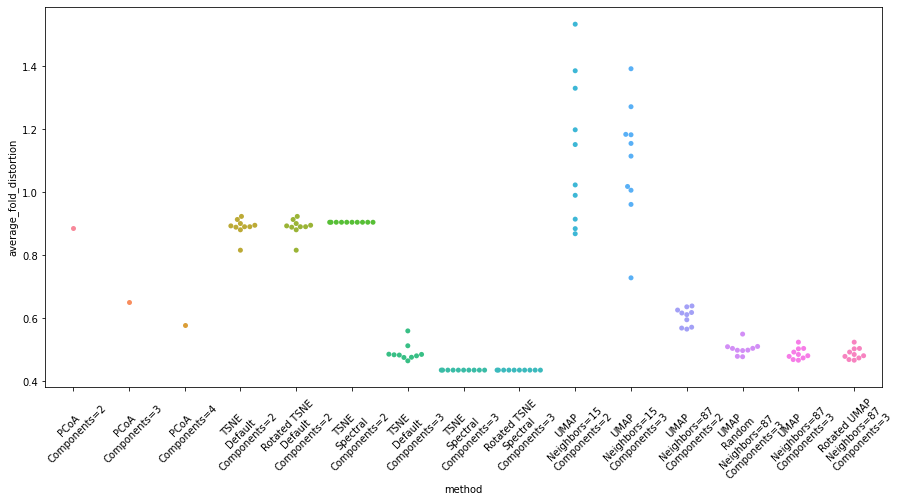

In [311]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
g = sns.swarmplot(
    x='method',
    y='average_fold_distortion',
    hue='method',
    data=results_df,
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


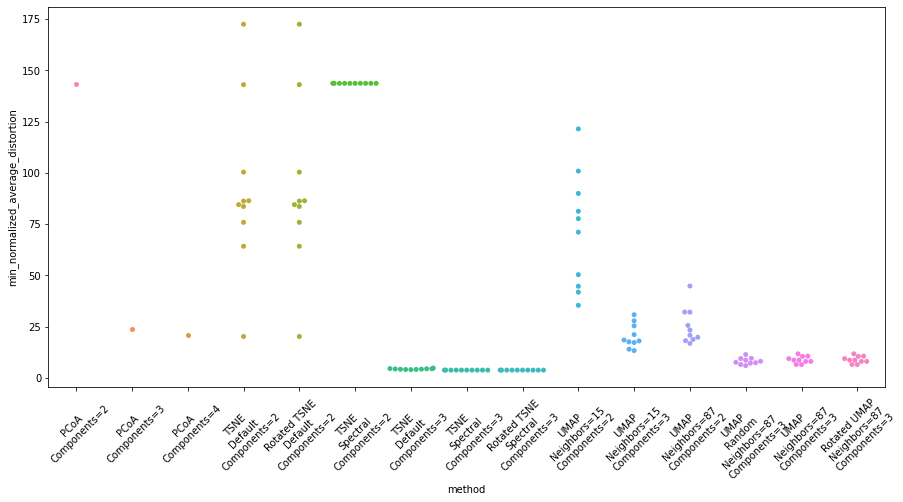

In [312]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))
g = sns.swarmplot(
    x='method',
    y='min_normalized_average_distortion',
    hue='method',
    data=results_df,
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


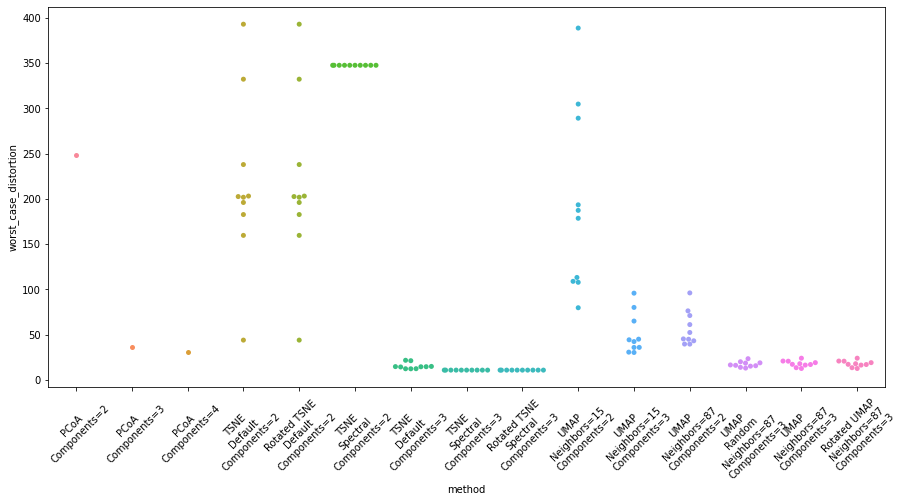

In [313]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.swarmplot(
    x='method',
    y='worst_case_distortion',
    hue='method',
    data=results_df,
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


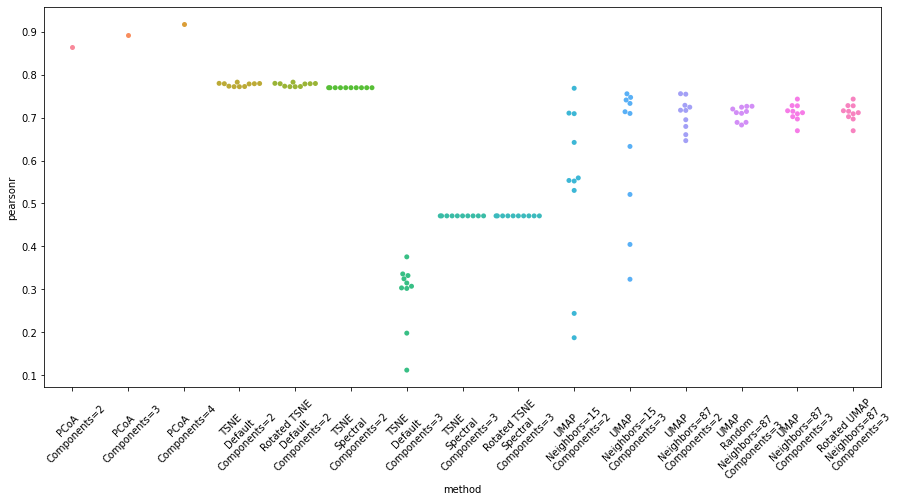

In [314]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.swarmplot(
    x='method',
    y='pearsonr',
    hue='method',
    data=results_df,
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


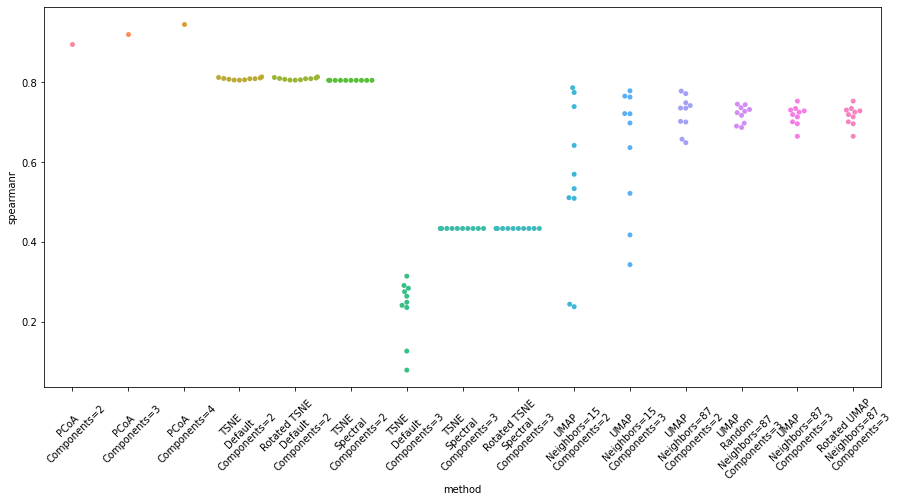

In [315]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.swarmplot(
    x='method',
    y='spearmanr',
    hue='method',
    data=results_df,
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

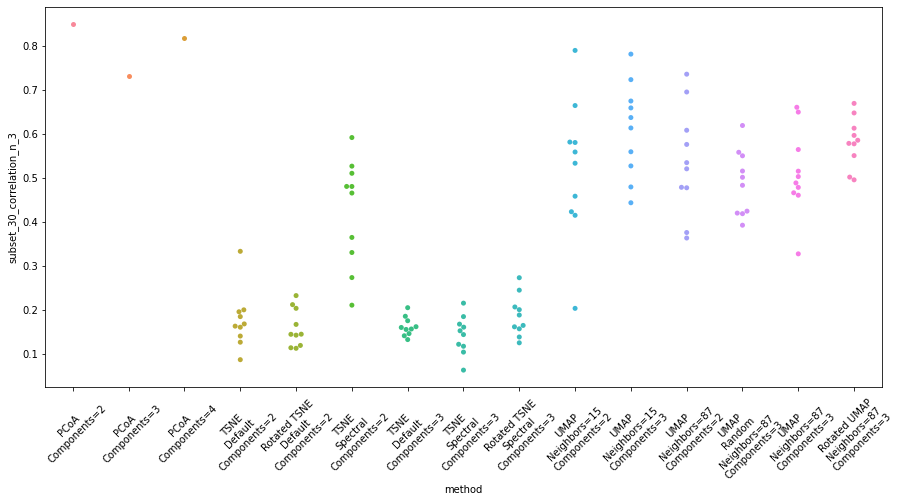

In [316]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.swarmplot(
    x='method',
    y='subset_30_correlation_n_3',
    hue='method',
    data=results_df,
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.legend().remove()

In [275]:
host_sample_type_order = ['M2-skin','M2-surface',  'M3-skin', 'M3-surface',  'M9-skin', 'M9-surface',]

In [276]:
tsne_def_2 = results_df.loc[results_df['method'] == 'TSNE\nDefault\nComponents=2']

tsne_ord_ = tsne_def_2.ordination.iloc[0]

sns.scatterplot(
    x='PC1',
    y='PC2',
    data=tsne_ord_,
    hue=metadata['host-sample_type'].values,
    hue_order = host_sample_type_order,
    palette='Paired',
)

<AxesSubplot:xlabel='method', ylabel='subset_30_correlation_n_3'>

In [277]:
umap_2 = results_df.loc[results_df['method'] == 'UMAP\nNeighbors=87\nComponents=2']

umap_ord_ = umap_2.ordination.iloc[0]

sns.scatterplot(
    x='PC1',
    y='PC2',
    data=umap_ord_,
    hue=metadata['host-sample_type'].values,
    hue_order = host_sample_type_order,
    palette='Paired',
)

<AxesSubplot:xlabel='method', ylabel='subset_30_correlation_n_3'>

In [278]:
pcoa_2 = results_df.loc[results_df['method'] == 'PCoA\nComponents=2']

pcoa_ord_ = pcoa_2.ordination.iloc[0]

sns.scatterplot(
    x='PC1',
    y='PC2',
    data=pcoa_ord_,
    hue=metadata['host-sample_type'].values,
    hue_order = host_sample_type_order,
    palette='Paired',
)

<AxesSubplot:xlabel='method', ylabel='subset_30_correlation_n_3'>

In [331]:
tsne_def_3 = results_df.loc[results_df['method'] == 'TSNE\nSpectral\nComponents=3']
tsne_ord_ = tsne_def_3.ordination.iloc[1]
tsne_def_2 = results_df.loc[results_df['method'] == 'TSNE\nSpectral\nComponents=2']
tsne_ord_2 = tsne_def_2.ordination.iloc[1]
umap_3 = results_df.loc[results_df['method'] == 'UMAP\nNeighbors=87\nComponents=3']
umap_ord_ = umap_3.ordination.iloc[0]
pcoa_3 = results_df.loc[results_df['method'] == 'PCoA\nComponents=3']
pcoa_ord_ = pcoa_3.ordination.iloc[0]

In [332]:
ords = [
    {
        'title': 'PCoA-3',
        'ordination': pcoa_ord_,
    },
    {
        'title': 'UMAP-3',
        'ordination': umap_ord_,
    },
    {
        'title': 'TSNE-3',
        'ordination': tsne_ord_,
    },
    {
        'title': 'TSNE-2',
        'ordination': tsne_ord_2,
    },
]

In [333]:
vals = list(sorted(list(set(metadata['host-sample_type'].values))))
cols = sns.color_palette('Paired').as_hex()
mapping = {val: col for val, col in zip(vals, cols)}

In [334]:
%matplotlib notebook

<ipython-input-348-8337d28b4529>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(raw_aitchison_dm, method='average',


<IPython.core.display.Javascript object>


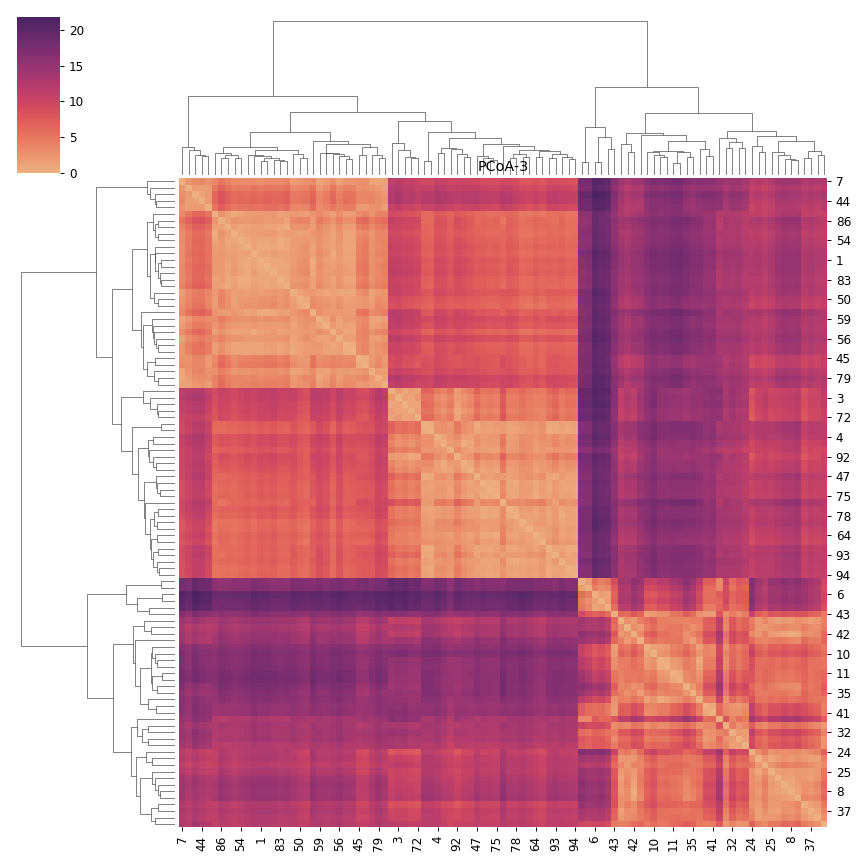

<IPython.core.display.Javascript object>


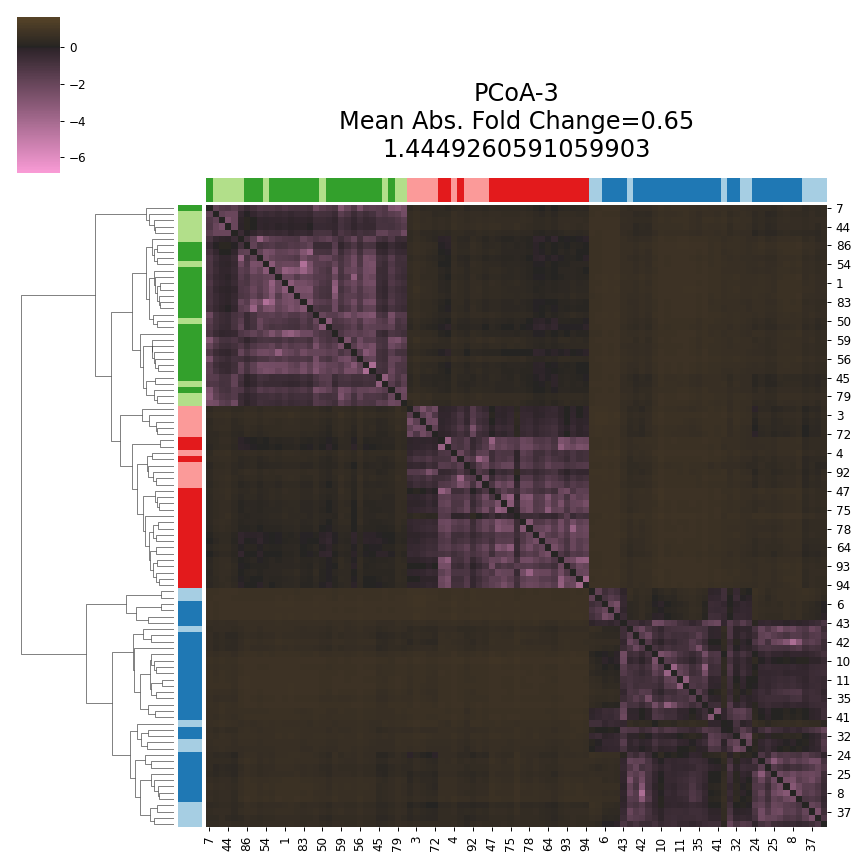

<IPython.core.display.Javascript object>


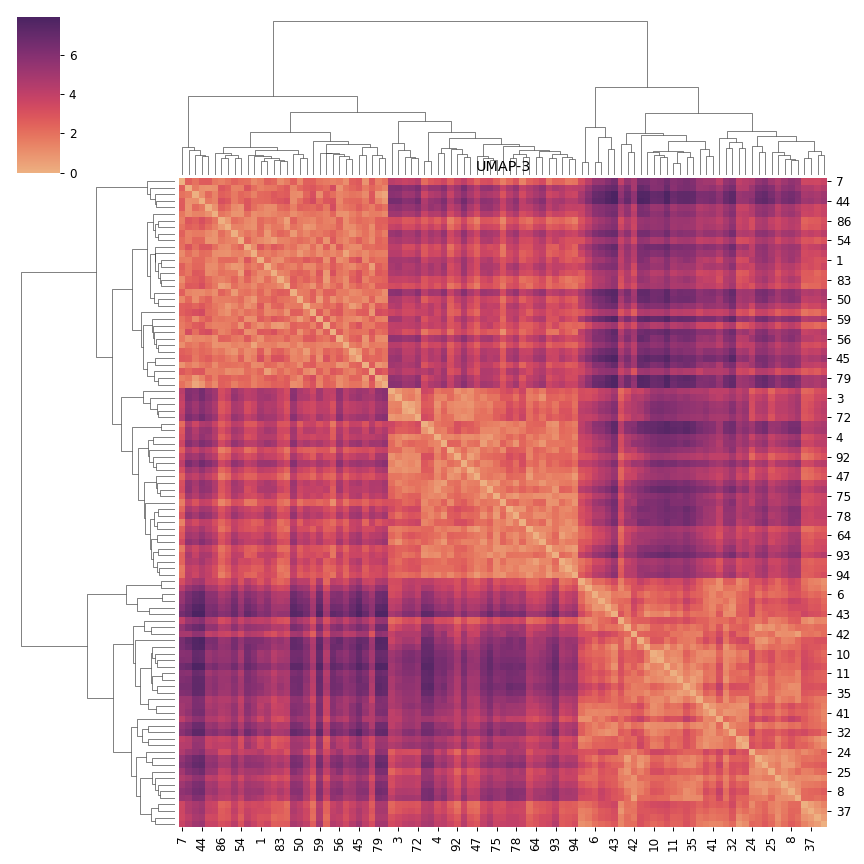

<IPython.core.display.Javascript object>


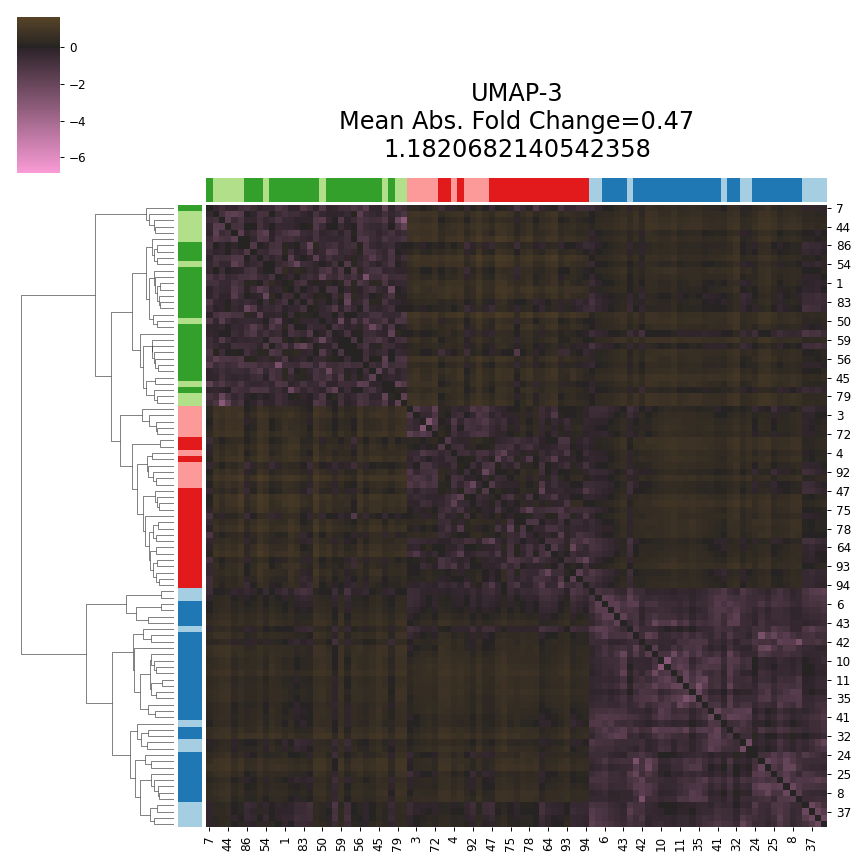

<IPython.core.display.Javascript object>


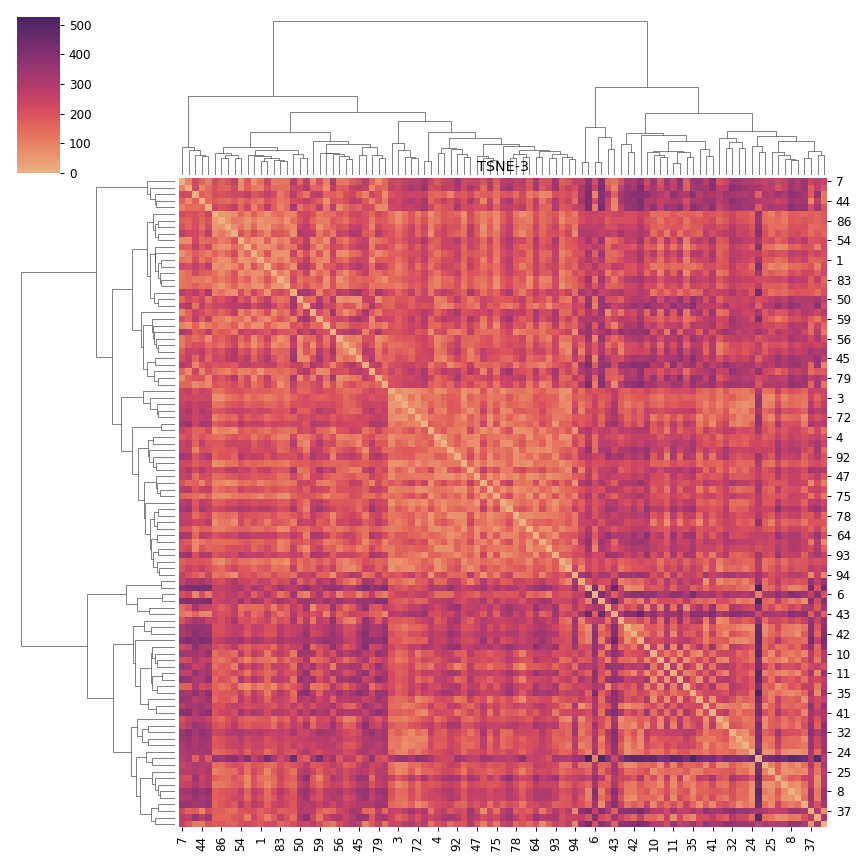

<IPython.core.display.Javascript object>


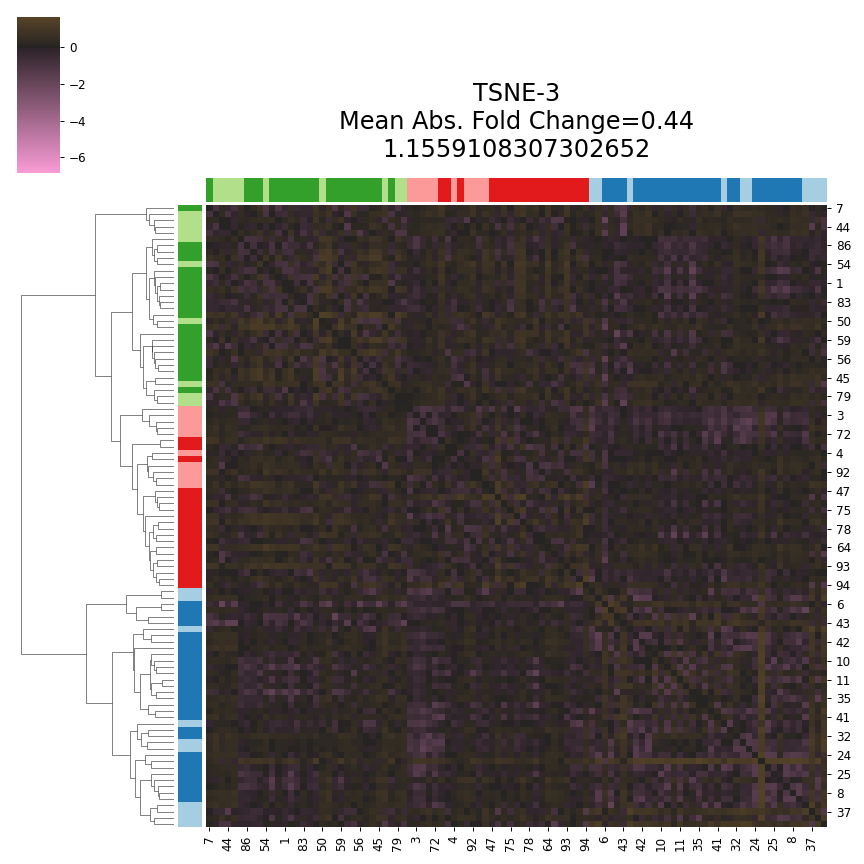

<IPython.core.display.Javascript object>


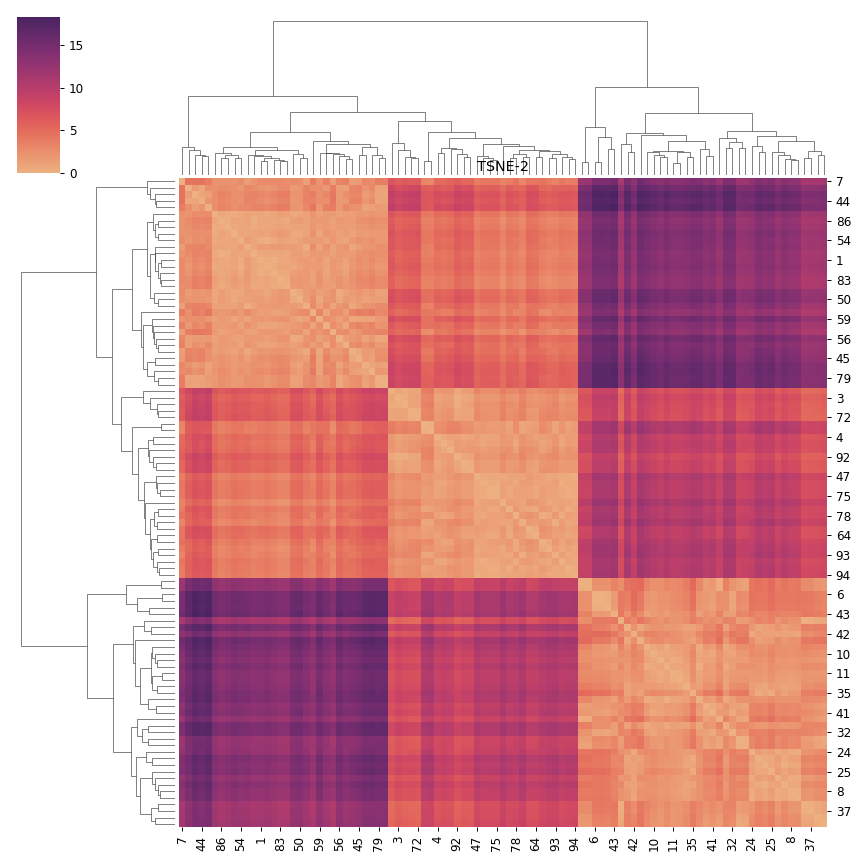

<IPython.core.display.Javascript object>


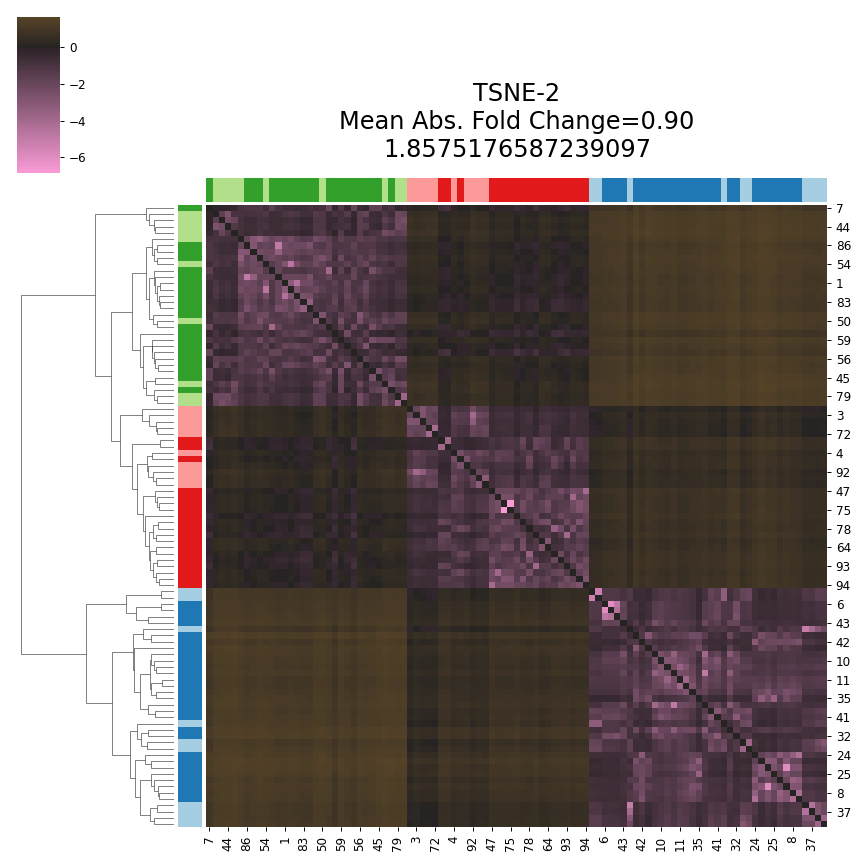

In [348]:
raw_aitchison_dm = cdist(prepped_table, prepped_table)
linkage = hierarchy.linkage(raw_aitchison_dm, method='average',
                            metric='braycurtis')
all_ratios = []
all_normalized_distance_ratios = []
for result in ords:
    embedding_dm = cdist(result['ordination'], result['ordination'])
    distance_ratios = pairwise_ratios(raw_aitchison_dm, embedding_dm[:, :])
    result['embedding_dm'] = embedding_dm
    np.fill_diagonal(distance_ratios, 1)
    result['distance_ratios'] = distance_ratios

    ratiomat = result['distance_ratios']
    logratios = np.log2(ratiomat)
    geom_mean = logratios[np.triu_indices_from(logratios, k=1)].mean()
    logratios = logratios - geom_mean
    np.fill_diagonal(logratios, 0)
    result['distance_ratios_normalized'] = logratios
    res = result['ordination']
    res.index = metadata.index
    res = res.join(metadata)
    all_ratios.append(distance_ratios)
    all_normalized_distance_ratios.append(logratios)

all_ratios = np.hstack(all_ratios)
all_normalized_distance_ratios = np.hstack(all_normalized_distance_ratios)
max_normalized_ratio = all_normalized_distance_ratios.max()
min_normalized_ratio = all_normalized_distance_ratios.min()
max_ratio = all_ratios.max()
min_ratio = all_ratios.min()

for result in ords:
    res = result['ordination']
    cmap = sns.diverging_palette(
        330,
        49,
        s=90,
        l=75,
        center='dark',
        as_cmap=True,
    )
    logratios = result['distance_ratios_normalized']

    g = sns.clustermap(
        result['embedding_dm'],
        row_linkage=linkage,
        col_linkage=linkage,
        cmap='flare',
    )
    g.ax_heatmap.set_title(result['title'])
    g = sns.clustermap(
        logratios,
        col_colors=list(map(mapping.get, metadata['host-sample_type'].to_numpy())),
        row_colors=list(map(mapping.get, metadata['host-sample_type'].to_numpy())),
        cmap=cmap,
        # vmin=-1,
        # vmax=1,
        vmax=max_normalized_ratio,
        vmin=min_normalized_ratio,
        center=0,
        row_linkage=linkage,
        col_linkage=linkage,
    )
    g.ax_col_dendrogram.set_visible(False)
    triu_ratios = logratios[np.triu_indices_from(logratios, k=1)]
    std = triu_ratios.std()
    mse = np.abs(triu_ratios).mean()
    distance_ratios = result['distance_ratios']
    raw_ratios = distance_ratios[np.triu_indices_from(logratios, k=1)]
    new_avg_distortion = raw_ratios.mean() * (1 / raw_ratios).mean()
    g.ax_heatmap.set_title(result['title'] +
                           # f'\nSTD={std:.2f}' +
                           f'\nMean Abs. Fold Change={mse:.2f}\n{new_avg_distortion}',
                           fontsize=20, pad=40)

<IPython.core.display.Javascript object>


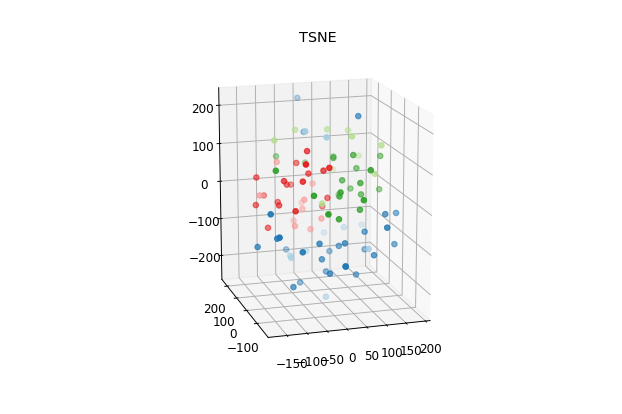

In [340]:
o = tsne_ord_
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = o['PC1']
ydata = o['PC2']
zdata = o['PC3']
ax.scatter3D(xdata, ydata, zdata, c=metadata['host-sample_type'].map(mapping).values, cmap='Paired')
ax.set_box_aspect((np.ptp(xdata), np.ptp(ydata), np.ptp(zdata)))
ax.set_title('TSNE')
plt.show()

<IPython.core.display.Javascript object>


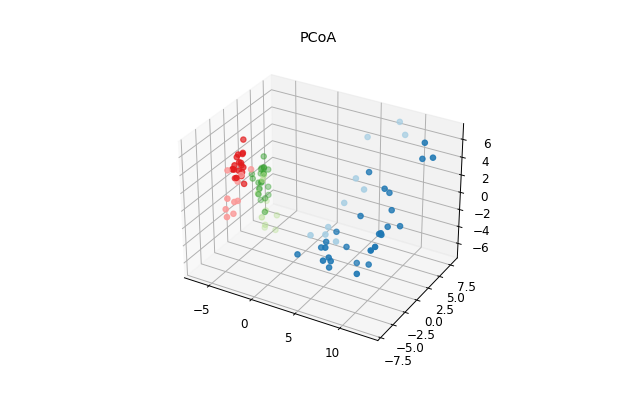

Text(0.5, 0.92, 'PCoA')

In [339]:
o = pcoa_ord_
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = o['PC1']
ydata = o['PC2']
zdata = o['PC3']
ax.scatter3D(xdata, ydata, zdata, c=metadata['host-sample_type'].map(mapping).values, cmap='Paired')
ax.set_box_aspect((np.ptp(xdata), np.ptp(ydata), np.ptp(zdata)))
ax.set_title('PCoA')

<IPython.core.display.Javascript object>


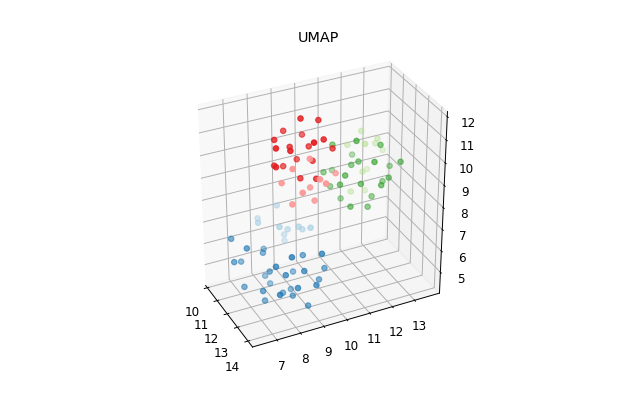

In [322]:
o = umap_ord_
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = o['PC1']
ydata = o['PC2']
zdata = o['PC3']
ax.set_title('UMAP')
ax.scatter3D(xdata, ydata, zdata, c=metadata['host-sample_type'].map(mapping).values, cmap='Paired')
ax.set_box_aspect((np.ptp(xdata), np.ptp(ydata), np.ptp(zdata)))

<IPython.core.display.Javascript object>


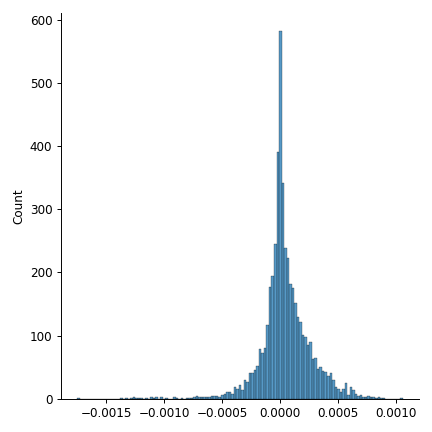

TSNE-3 0.22910992777394684


<IPython.core.display.Javascript object>


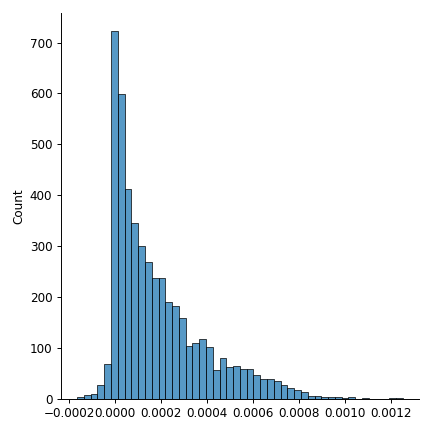

PCoA-3 0.9081151148051767


<IPython.core.display.Javascript object>


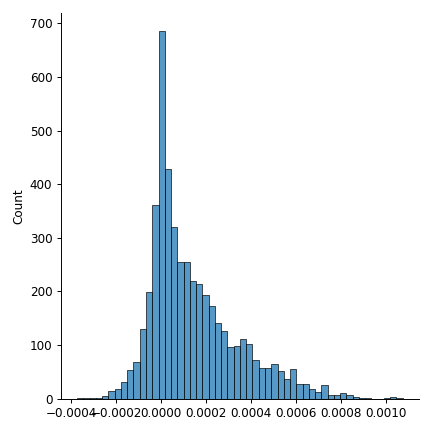

UMAP-3 0.6864833759449075


In [298]:
original_triu_distances = cdist(prepped_table, prepped_table)[np.triu_indices(len(coords), k=1)]
for ordination in ords:
    coords = ordination['ordination']
    ordination['distances'] = cdist(coords, coords)
    triu_distances = ordination['distances'][np.triu_indices(len(coords), k=1)]
    
    ordination['xs'] = (original_triu_distances - original_triu_distances.mean())
    ordination['ys'] = triu_distances - triu_distances.mean()
    ordination['denom'] = np.sqrt((ordination['xs'] ** 2).sum() * \
                                  (ordination['ys'] ** 2).sum())
    corr_comps = ordination['xs'] * ordination['ys'] / ordination['denom']
    g = sns.displot(corr_comps)
    print(ordination['title'], corr_comps.sum())
    plt.show()
    
    